In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import io
from scipy import misc
import pydotplus
import collections
from sklearn import tree
from sklearn.tree import export_graphviz
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Write a small paragraph describing the dataset that you choose, its features, number of instances, nature of the data, and anything else that you found to be interesting.

I chose to use the servo dataset https://archive.ics.uci.edu/ml/datasets/Servo. This data set is interesting to me because in my full time job my team and I just launched a smart lock project that uses a motor to open and close the deadbolt on a user's door. We had a lot of challenges picking the right motor and calibrating it with different deadbolts. 

Description from Author: "This is an interesting collection of data provided by Karl Ulrich. It covers an extremely non-linear phenomenon - predicting the rise time of a servomechanism in terms of two (continuous) gain settings and two (discrete) choices of mechanical linkages."

Attribute Information:

1. motor: A,B,C,D,E
2. screw: A,B,C,D,E
3. pgain: 3,4,5,6
4. vgain: 1,2,3,4,5
5. class: 0.13 to 7.10

167 Instances

# 2. Provide a brief analysis of the dataset you downloaded. Does it have missing data? Are the features numeric/discrete/categorical? Create some histograms/boxplots/other visualizations to illustrate the content of the dataset.

There is no missing data in this dataset. However, the first two features are character strings making the dataset alpha-numeric. Further down in the assignment I will actually convert the "screws" feature to numerical values to make it possible to apply it to the training method. Below I have made some different graph types we have seen in class, and a few extra that I have used in other projects.



In [159]:
servo_data = pd.read_csv('servo.data',
                           names = ["motor", "screw", "pgain", "vgain", "class"], sep= ',', header= None)

In [160]:
servo_data.describe(include="all")

motor screw       pgain       vgain       class
count    167   167  167.000000  167.000000  167.000000
unique     5     5         NaN         NaN         NaN
top        C     A         NaN         NaN         NaN
freq      40    42         NaN         NaN         NaN
mean     NaN   NaN    4.155689    2.538922    1.389708
std      NaN   NaN    1.017770    1.369850    1.559635
min      NaN   NaN    3.000000    1.000000    0.131250
25%      NaN   NaN    3.000000    1.000000    0.503126
50%      NaN   NaN    4.000000    2.000000    0.731254
75%      NaN   NaN    5.000000    4.000000    1.259369
max      NaN   NaN    6.000000    5.000000    7.100108

In [161]:
servo_data["motor"] =  servo_data["motor"].astype('category')

In [162]:
servo_data.dtypes

motor    category
screw      object
pgain       int64
vgain       int64
class     float64
dtype: object

In [163]:
servo_data.shape

(167, 5)

In [164]:
servo_data.head()

motor screw  pgain  vgain     class
0     E     E      5      4  0.281251
1     B     D      6      5  0.506252
2     D     D      4      3  0.356251
3     B     A      3      2  5.500033
4     D     B      6      5  0.356251

In [165]:
# How many of each motor there are
servo_data["motor"].value_counts()

C    40
B    36
A    36
E    33
D    22
Name: motor, dtype: int64

In [166]:
# How many of each screw there are
servo_data["screw"].value_counts()

A    42
B    35
C    31
D    30
E    29
Name: screw, dtype: int64

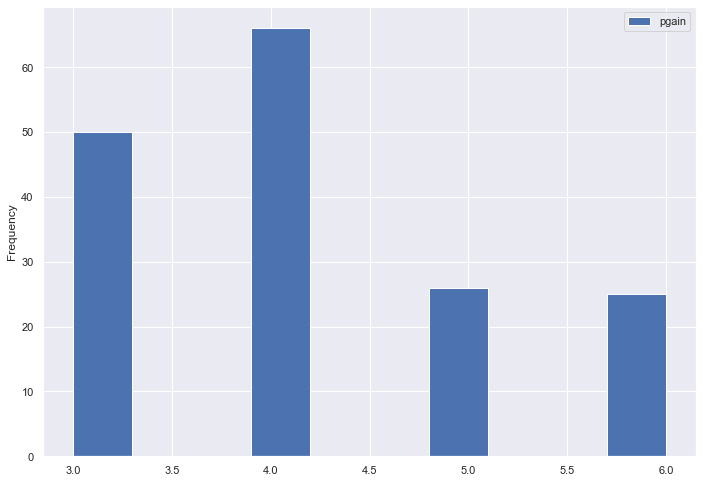

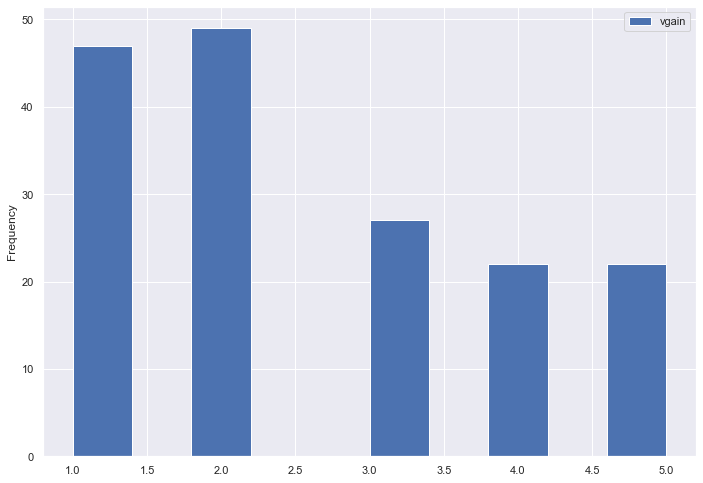

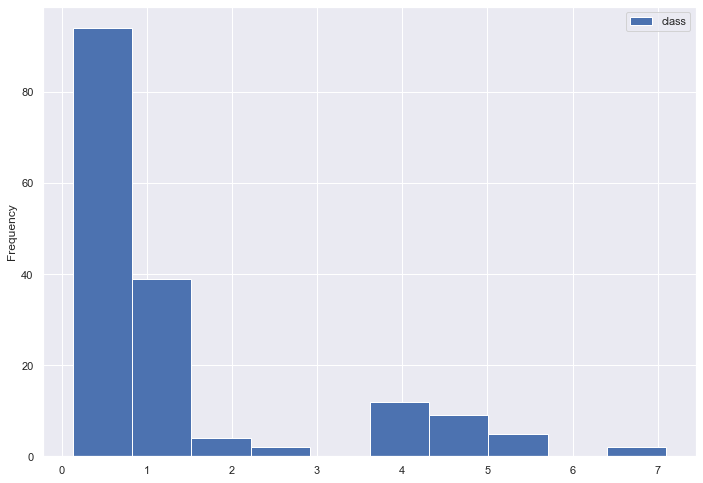

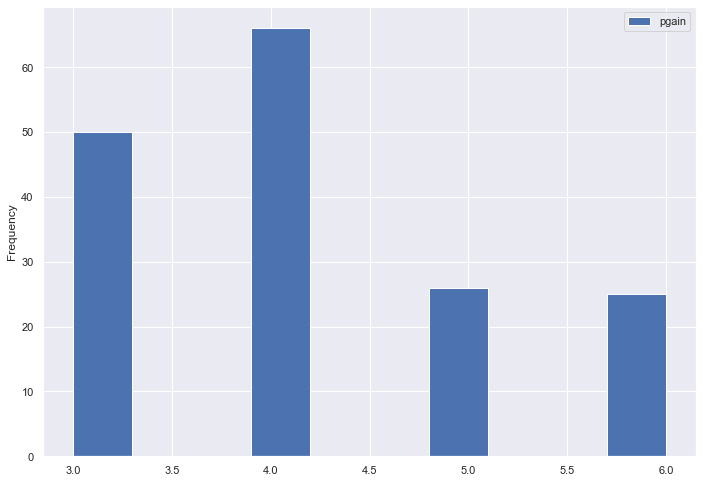

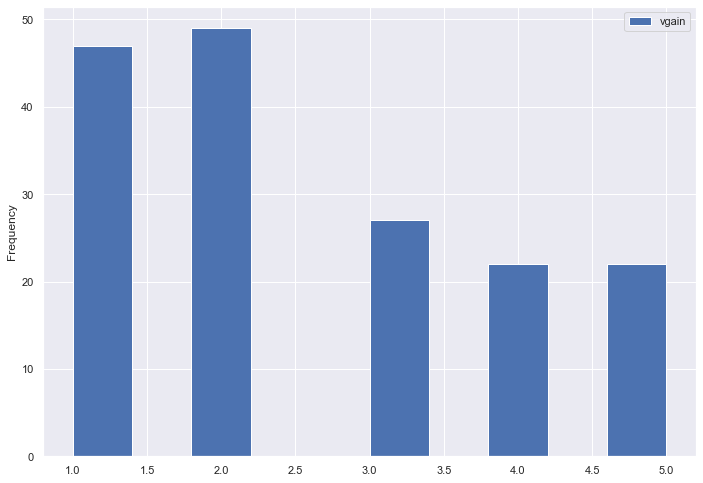

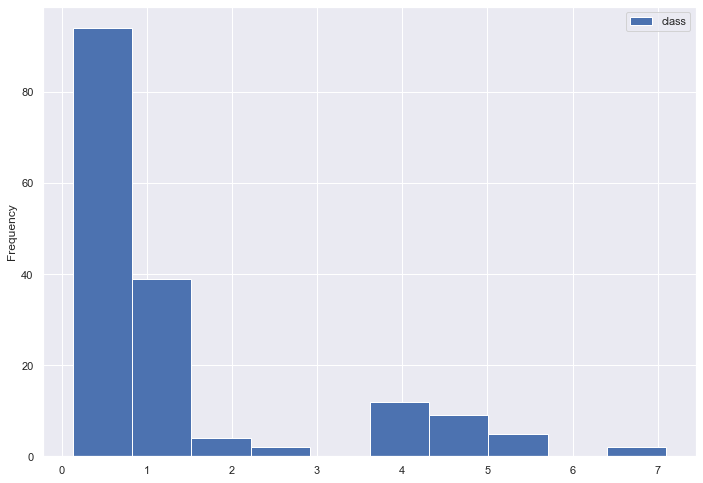

In [167]:
# Make some histograms for motor and screw type to other features
servo_data.plot(kind="hist", x="screw", y="pgain")
servo_data.plot(kind="hist", x="screw", y="vgain")
servo_data.plot(kind="hist", x="screw", y="class")
servo_data.plot(kind="hist", x="motor", y="pgain")
servo_data.plot(kind="hist", x="motor", y="vgain")
servo_data.plot(kind="hist", x="motor", y="class")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

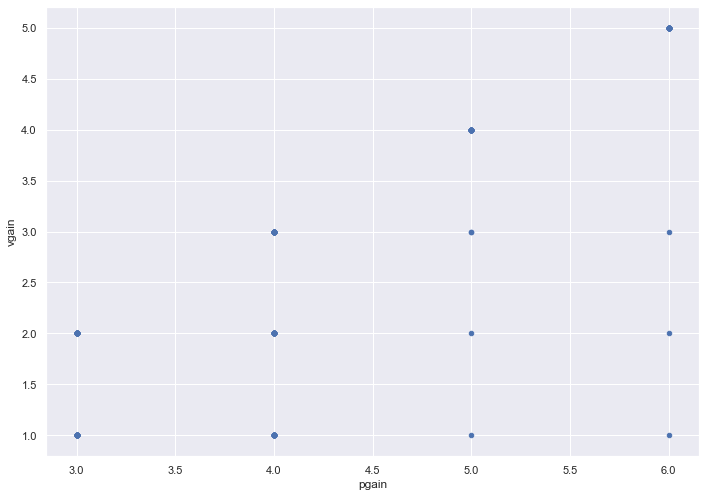

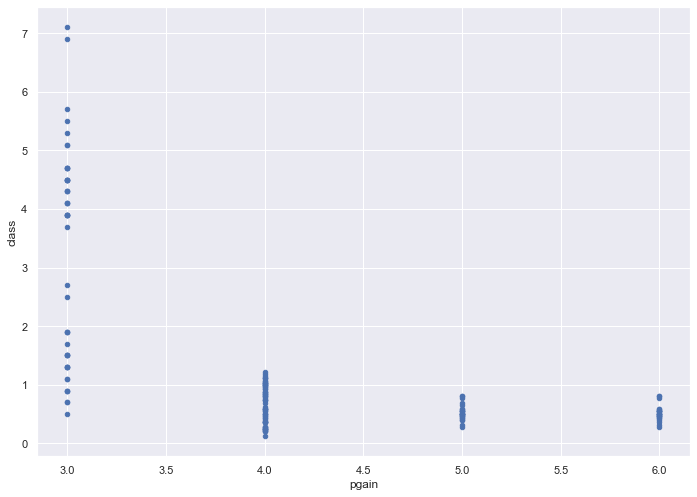

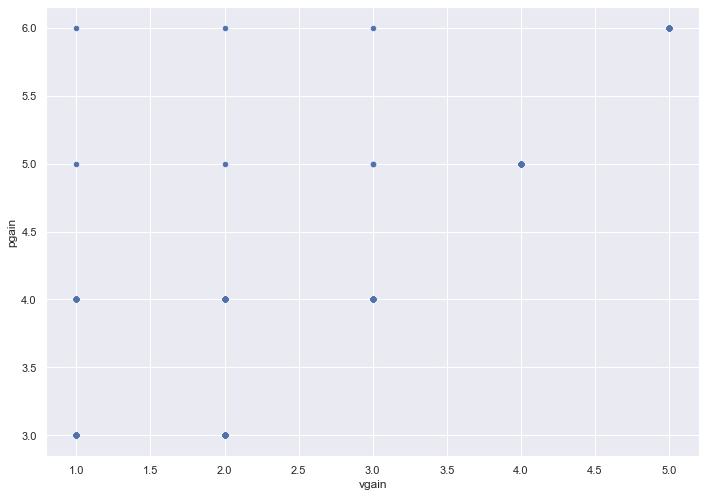

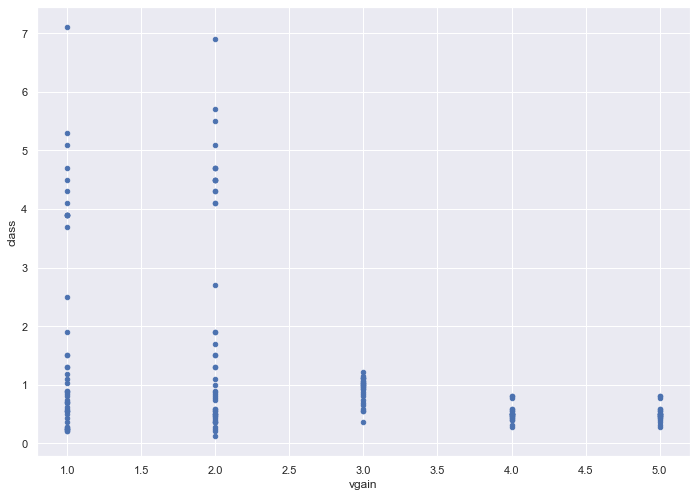

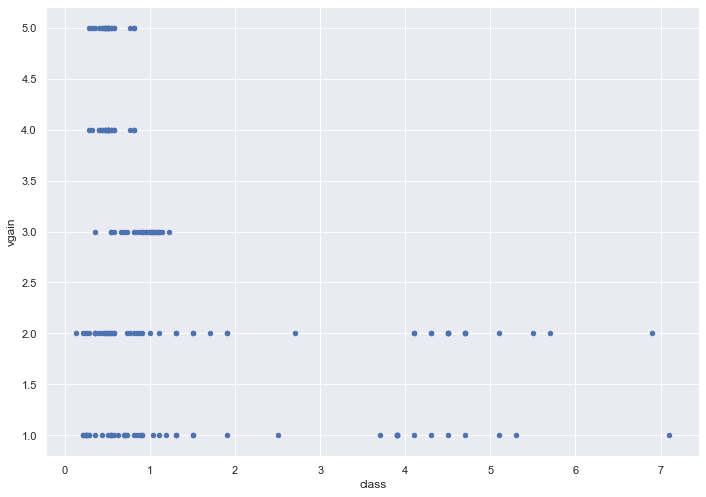

In [168]:
# Make some scatter plots of numeric features
servo_data.plot(kind="scatter", x="pgain", y="vgain")
servo_data.plot(kind="scatter", x="pgain", y="class")
servo_data.plot(kind="scatter", x="vgain", y="pgain")
servo_data.plot(kind="scatter", x="vgain", y="class")
servo_data.plot(kind="scatter", x="class", y="pgain")
servo_data.plot(kind="scatter", x="class", y="vgain")


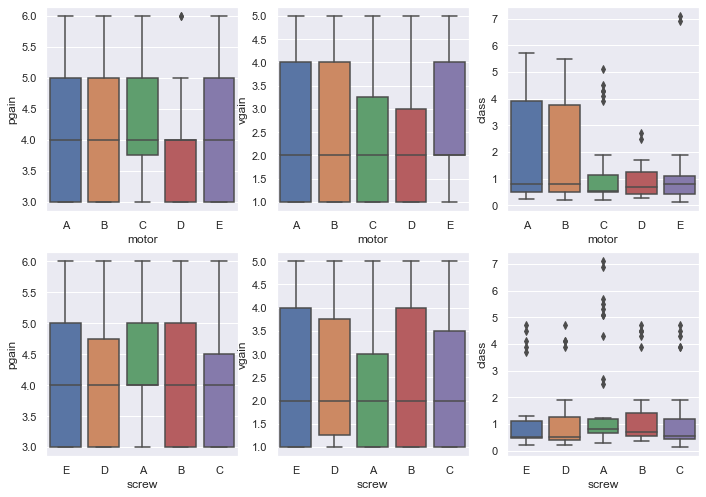

In [169]:
# Box plots can help better relate alphanumeric relationships between the data
sns.set(style="white", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
f, axes = plt.subplots(2, 3)
sns.boxplot(x="motor", y="pgain", data=servo_data, ax=axes[0][0])
sns.boxplot(x="motor", y="vgain", data=servo_data, ax=axes[0][1])
sns.boxplot(x="motor", y="class", data=servo_data, ax=axes[0][2])
sns.boxplot(x="screw", y="pgain", data=servo_data, ax=axes[1][0])
sns.boxplot(x="screw", y="vgain", data=servo_data, ax=axes[1][1])
sns.boxplot(x="screw", y="class", data=servo_data, ax=axes[1][2])

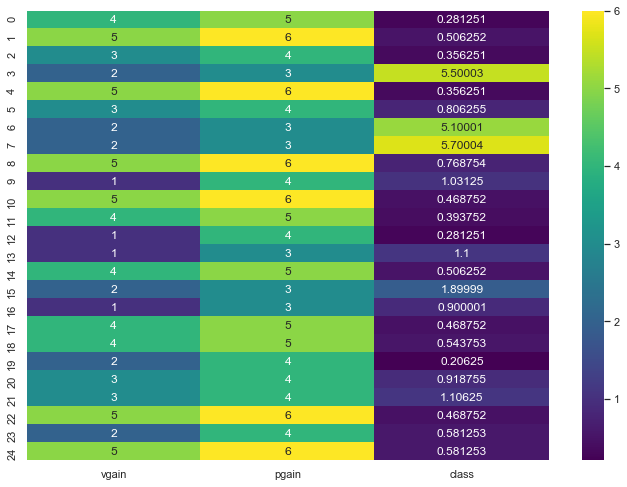

In [170]:
# Heat map to show the numeric value representation of 
sns.heatmap(servo_data[['vgain','pgain','class']][:25], annot=True, fmt="g", cmap='viridis')
plt.show()

# 3. Using scikit-learnâ€™s DecisionTreeClassifier, train a supervised learning model that can be used to generate predicions for your data. A reference to how you can do that can be found on scikit-learn.

In [171]:
#servo_data['screw'] = (servo_data['screw'] != 'A'
servo_data['screw'] = servo_data['screw'].map({'A': 0, 'B': 1,'C': 2, 'D': 3,'E': 4})


In [172]:
servo_data['screw'].value_counts()

0    42
1    35
2    31
3    30
4    29
Name: screw, dtype: int64

In [173]:
# Since screw is also a character I converted it to a numeric value for this
X = servo_data.values[:, 1:5]
Y = servo_data.values[:,0]

In [174]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 100)

In [175]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf = clf_gini.fit(X_train, y_train)

In [176]:
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [177]:
y_pred = clf_gini.predict(X_test)
y_pred_en = clf_entropy.predict(X_test)

In [178]:
print ("Accuracy for decision tree with gini index as criteria is ", accuracy_score(y_test,y_pred)*100)

Accuracy for decision tree with gini index as criteria is  20.588235294117645


In [179]:
print("Accuracy for decision tree with entropy as criteria is ", accuracy_score(y_test,y_pred_en)*100)

Accuracy for decision tree with entropy as criteria is  20.588235294117645


# 4. The link above explains how you can generate a visual output for the tree you just trained. Use that code snippet to create a visualization of your tree.

In [180]:
# Visualize data
import pydotplus
import collections
from sklearn import tree

data_feature_names = ["screw", "pgain", "vgain", "class"]
dot_data = tree.export_graphviz(clf,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

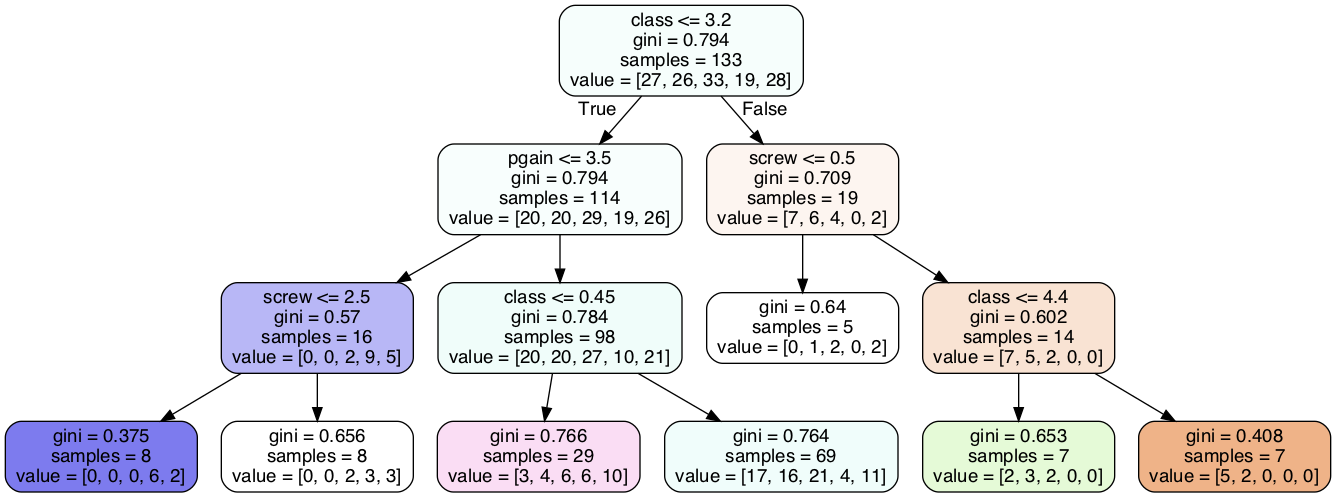

In [181]:
from IPython.display import Image
Image("img/tree.png")

5. Create a new instance with your choice of values for each of the features. Use your trained
model to generate a prediction for it. Using your tree illustration as a reference, write a
short paragraph describing how your model went about generating that specific prediction.
Does it make sense to you? Can it be improved? Go back and play with the parameters
that you used for training your tree and see if you can obtain better results.

In [182]:
clf.predict([[2, 1, 4, 2]])

array(['D'], dtype=object)

# class <= 3.2 is True
# then pgain <= 3.5 is True
# then  screw <= 2.5 is False
# so the category for this instance is D
This the the path that the prediction followed in the above chart. The prediction is correct, but we can see that the outcome sets are colored very differently so the results will not be very overlapping. 

In [183]:
clf_gini_new = DecisionTreeClassifier(criterion = "gini", random_state = 100)
clf = clf_gini_new.fit(X_train, y_train)

In [184]:
clf_entropy_new = DecisionTreeClassifier(criterion = "entropy", random_state = 100)
clf_entropy_new.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [185]:
y_pred_new = clf_gini_new.predict(X_test)
y_pred_en_new = clf_entropy_new.predict(X_test)


# Results with new parameters

In [186]:
print ("Accuracy for decision tree with gini index as criteria is ", accuracy_score(y_test,y_pred_new)*100)

Accuracy for decision tree with gini index as criteria is  8.823529411764707


In [187]:
print ("Accuracy for decision tree with entropy as criteria is ", accuracy_score(y_test,y_pred_en_new)*100)

Accuracy for decision tree with entropy as criteria is  11.76470588235294


We can see that by using different parameters (just the defaults) it decreased our accuracy by more than 50% from 20 to 8(gini index criteria)! This is most likely due to not having a large sample set, and not a lot of variance in the feature values. 

In [188]:
data_feature_names = ["screw", "pgain", "vgain", "class"]
dot_data = tree.export_graphviz(clf_gini_new,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree1.png')

True

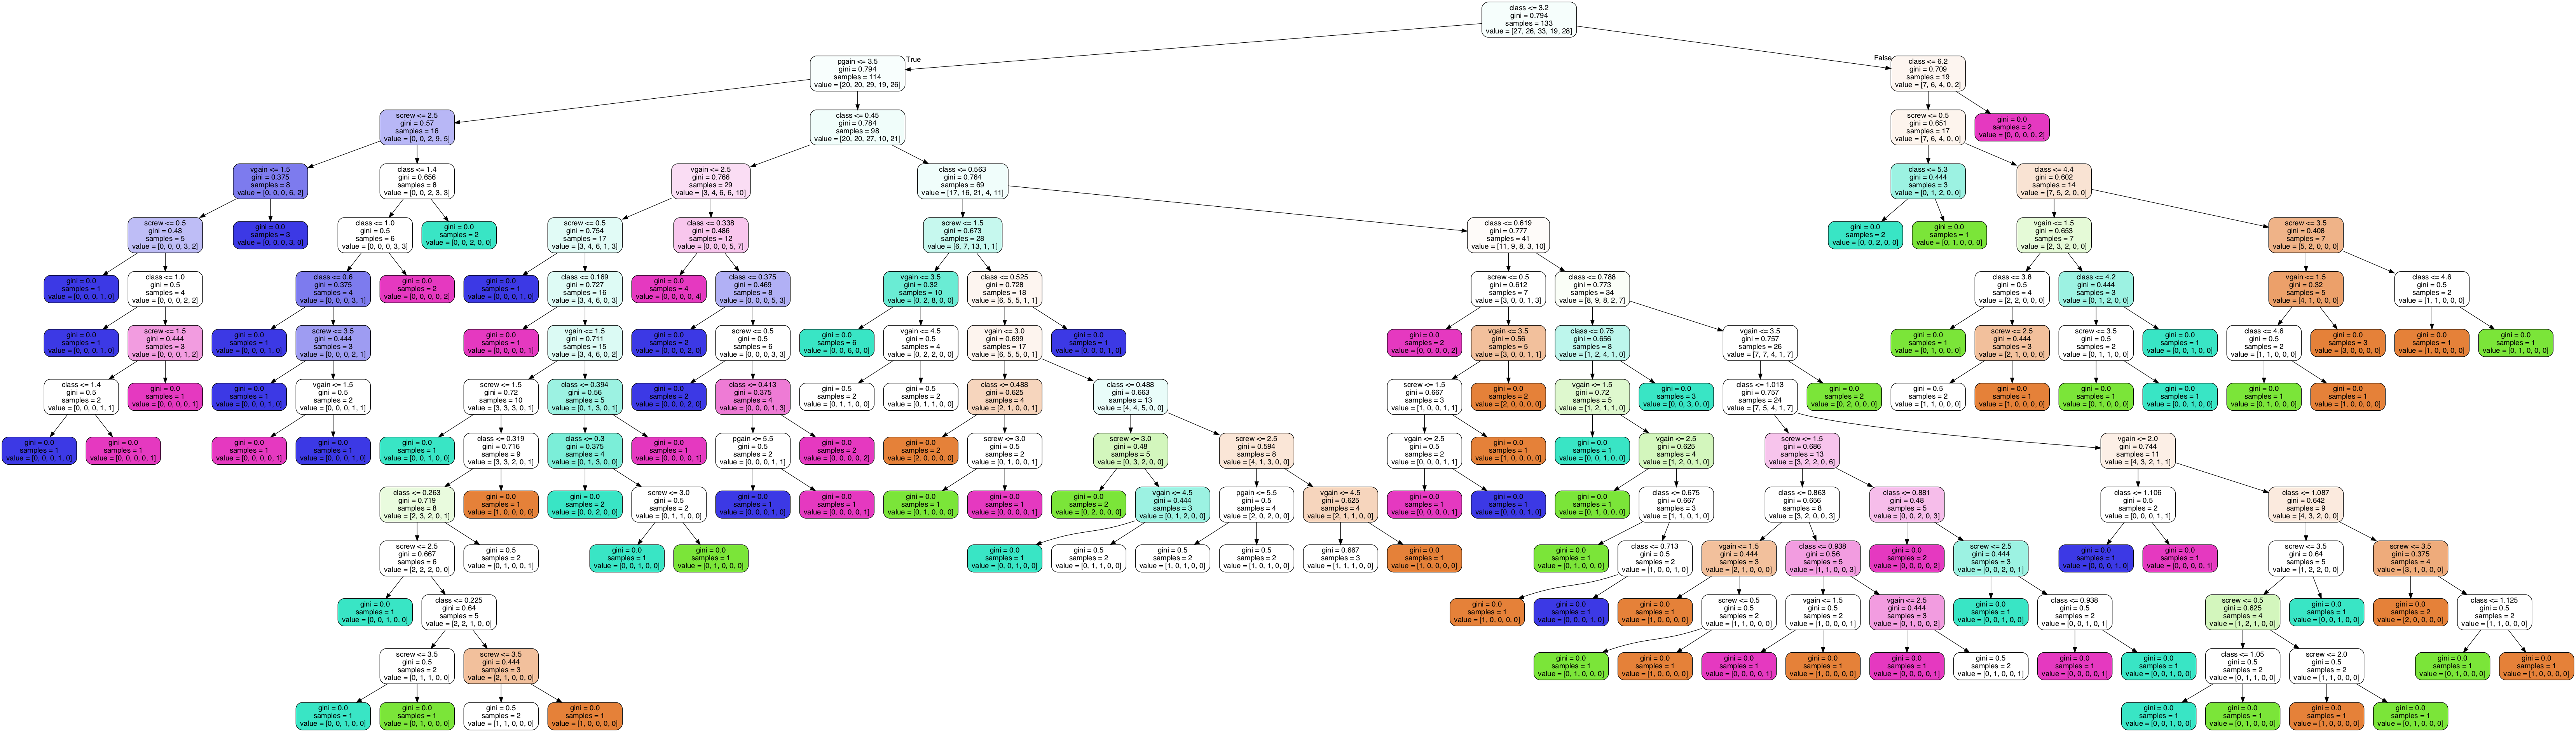

In [157]:
Image("tree1.png")

In [156]:
clf.predict([[2, 1, 4, 2]])

array(['D'], dtype=object)

Even though the tree is now much larger, we still end up with the same prediction, D, as before. Now there are a lot more outcomes which can be a result of lower accuracy and actually overfitting due to fewer parameter restrictions and fewer overall feature variability per motor type.

In [189]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 5),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()
# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_*100))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 4}
Best score is 29.32330827067669


# Best results
To get the best results, we can use randomized search CV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
to find the most optimal parameter values. We can see that this did indeed give us a better accuracy score of 29.3 which is almost a 50% improvement from our first attempt (20)!